In [1]:
!pip install 'sagemaker>=2,<3'

In [2]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::730456550509:role/service-role/AmazonSageMaker-ExecutionRole-20210612T184349
CPU times: user 954 ms, sys: 166 ms, total: 1.12 s
Wall time: 13.3 s


In [5]:
bucket = sess.default_bucket()
prefix = "semantic-segmentation-demo"
print(bucket)
# bucket_name = 'petsdata-sx'

sagemaker-eu-west-2-730456550509


In [6]:
training_image = sagemaker.image_uris.retrieve("semantic-segmentation", sess.boto_region_name)
print(training_image)

644912444149.dkr.ecr.eu-west-2.amazonaws.com/semantic-segmentation:1


In [7]:
print("Downloading the dataset...")
!wget -P /tmp https://fast-ai-imagelocal.s3.amazonaws.com/pascal-voc.tgz
# S3 cp may be even faster on environments where it's available:
# !aws s3 cp s3://fast-ai-imagelocal/pascal-voc.tgz /tmp/pascal-voc.tgz

print("Extracting VOC2012...")
!tar -xf /tmp/pascal-voc.tgz --wildcards pascal-voc/VOC2012*

print("Deleting /tmp files...")
!rm /tmp/pascal-voc.tgz

# Alternatively could consider using the Oxford Uni source:
#!wget -P /tmp http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#!tar -xf /tmp/VOCtrainval_11-May-2012.tar -C pascal-voc/VOC2012
#!rm /tmp/VOCtrainval_11-May-2012.tar

print("Done!")

--2022-02-15 19:53:52--  https://fast-ai-imagelocal.s3.amazonaws.com/pascal-voc.tgz
Resolving fast-ai-imagelocal.s3.amazonaws.com (fast-ai-imagelocal.s3.amazonaws.com)... 52.216.112.19
Connecting to fast-ai-imagelocal.s3.amazonaws.com (fast-ai-imagelocal.s3.amazonaws.com)|52.216.112.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4639722845 (4.3G) [application/x-tar]
Saving to: ‘/tmp/pascal-voc.tgz’

pascal-voc.tgz      100%[===================>]   4.32G  14.7MB/s    in 8m 26s  

2022-02-15 20:02:19 (8.74 MB/s) - ‘/tmp/pascal-voc.tgz’ saved [4639722845/4639722845]

Extracting VOC2012...
Deleting /tmp files...
Done!


In [11]:
import os
import shutil

# Create directory structure mimicing the s3 bucket where data is to be dumped.
VOC2012 = "pascal-voc/VOC2012"
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/validation", exist_ok=True)
os.makedirs("data/train_annotation", exist_ok=True)
os.makedirs("data/validation_annotation", exist_ok=True)

# Create a list of all training images.
with open(VOC2012 + "/ImageSets/Segmentation/train.txt") as f:
    train_list = f.read().splitlines()

# Create a list of all validation images.
with open(VOC2012 + "/ImageSets/Segmentation/val.txt") as f:
    val_list = f.read().splitlines()

# Move the jpg images in training list to train directory and png images to train_annotation directory.
for i in train_list:
    shutil.copy2(VOC2012 + "/JPEGImages/" + i + ".jpg", "data/train/")
    shutil.copy2(VOC2012 + "/SegmentationClass/" + i + ".png", "data/train_annotation/")

# Move the jpg images in validation list to validation directory and png images to validation_annotation directory.
for i in val_list:
    shutil.copy2(VOC2012 + "/JPEGImages/" + i + ".jpg", "data/validation/")
    shutil.copy2(VOC2012 + "/SegmentationClass/" + i + ".png", "data/validation_annotation/")

In [10]:
 rm -r 'data'

In [12]:
import glob

num_training_samples = len(glob.glob1("data/train", "*.jpg"))
num_validation_samples = len(glob.glob1("data/validation", "*.jpg"))

print("Num Train Images = " + str(num_training_samples))
assert num_training_samples == len(glob.glob1("data/train_annotation", "*.png"))

print("Num Validation Images = " + str(num_validation_samples))
assert num_validation_samples == len(glob.glob1("data/validation_annotation", "*.png"))

Num Train Images = 1464
Num Validation Images = 1449


In [13]:
%%time
train_channel = sess.upload_data(path="data/train", bucket=bucket, key_prefix=prefix + "/train")
print(train_channel)
train_annotation_channel = sess.upload_data(
    path="data/train_annotation",
    bucket=bucket,
    key_prefix=prefix + "/train_annotation",
)
print(train_annotation_channel)
validation_channel = sess.upload_data(
    path="data/validation", bucket=bucket, key_prefix=prefix + "/validation"
)
print(validation_channel)
validation_annotation_channel = sess.upload_data(
    path="data/validation_annotation",
    bucket=bucket,
    key_prefix=prefix + "/validation_annotation",
)
print(validation_annotation_channel)

s3://sagemaker-eu-west-2-730456550509/semantic-segmentation-demo/train
s3://sagemaker-eu-west-2-730456550509/semantic-segmentation-demo/train_annotation
s3://sagemaker-eu-west-2-730456550509/semantic-segmentation-demo/validation
s3://sagemaker-eu-west-2-730456550509/semantic-segmentation-demo/validation_annotation
CPU times: user 41.3 s, sys: 2.36 s, total: 43.7 s
Wall time: 4min 42s


In [15]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)
print(s3_output_location)

s3://sagemaker-eu-west-2-730456550509/semantic-segmentation-demo/output


In [16]:
ss_estimator = sagemaker.estimator.Estimator(
    training_image,  # Container image URI
    role,  # Training job execution role with permissions to access our S3 bucket
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    volume_size=50,  # in GB
    max_run=360000,  # in seconds
    output_path=s3_output_location,
    base_job_name="ss-notebook-demo",
    sagemaker_session=sess,
)

In [17]:
# Setup hyperparameters
ss_estimator.set_hyperparameters(
    backbone="resnet-50",  # This is the encoder. Other option is resnet-101
    algorithm="fcn",  # This is the decoder. Other options are 'psp' and 'deeplab'
    use_pretrained_model="True",  # Use the pre-trained model.
    crop_size=240,  # Size of image random crop.
    num_classes=21,  # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10,  # Number of epochs to run.
    learning_rate=0.0001,
    optimizer="rmsprop",  # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler="poly",  # Other options include 'cosine' and 'step'.
    mini_batch_size=16,  # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True,  # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=2,  # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10,  # No matter what, run these many number of epochs.
    num_training_samples=num_training_samples,  # This is a mandatory parameter, 1464 in this case.
)

In [19]:
distribution = "FullyReplicated"

data_channels = {
    "train": sagemaker.inputs.TrainingInput(train_channel, distribution=distribution),
    "validation": sagemaker.inputs.TrainingInput(validation_channel, distribution=distribution),
    "train_annotation": sagemaker.inputs.TrainingInput(
        train_annotation_channel, distribution=distribution
    ),
    "validation_annotation": sagemaker.inputs.TrainingInput(
        validation_annotation_channel, distribution=distribution
    ),
    # 'label_map': label_map_channel
}

In [20]:
ss_estimator.fit(data_channels, logs=True)

2022-02-15 20:41:35 Starting - Starting the training job...ProfilerReport-1644957695: InProgress
...
2022-02-15 20:42:19 Starting - Preparing the instances for training......
2022-02-15 20:43:21 Downloading - Downloading input data......
2022-02-15 20:44:31 Training - Downloading the training image...
2022-02-15 20:45:00 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[02/15/2022 20:44:55 INFO 139954891650880 integration.py:636] worker started
[02/15/2022 20:44:55 INFO 139954891650880] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'backbone': 'resnet-50', 'algorithm': 'fcn', 'use_pretrained_model': 'True', 'crop_size': '240', 'epochs': '10', 'learning_rate': '0.001', 'optimizer': 'sgd', 'lr_scheduler': 'poly', 'lr_scheduler_factor': '0.1', 'weight_decay': '0.0001',

In [21]:
ss_predictor = ss_estimator.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")

------!

In [22]:
filename_raw = "data/test.jpg"

!wget -O $filename_raw https://upload.wikimedia.org/wikipedia/commons/b/b4/R1200RT_in_Hongkong.jpg

--2022-02-15 21:04:57--  https://upload.wikimedia.org/wikipedia/commons/b/b4/R1200RT_in_Hongkong.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1047212 (1023K) [image/jpeg]
Saving to: ‘data/test.jpg’

data/test.jpg       100%[===================>]   1023K  2.98MB/s    in 0.3s    

2022-02-15 21:04:57 (2.98 MB/s) - ‘data/test.jpg’ saved [1047212/1047212]



Matplotlib is building the font cache; this may take a moment.


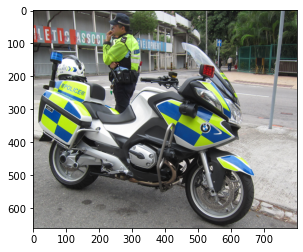

In [23]:
from matplotlib import pyplot as plt
import PIL

%matplotlib inline

filename = "data/test_resized.jpg"
width = 800

im = PIL.Image.open(filename_raw)

aspect = im.size[0] / im.size[1]

im.thumbnail([width, int(width / aspect)], PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

In [24]:
from PIL import Image
import numpy as np


class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


ss_predictor.deserializer = ImageDeserializer(accept="image/png")

In [25]:
ss_predictor.serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")

with open(filename, "rb") as imfile:
    imbytes = imfile.read()

In [26]:
%%time

cls_mask = ss_predictor.predict(imbytes)

print(type(cls_mask))
print(cls_mask.shape)

<class 'numpy.ndarray'>
(660, 799)
CPU times: user 130 ms, sys: 11.1 ms, total: 142 ms
Wall time: 10.1 s


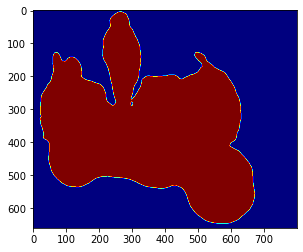

In [27]:
plt.imshow(cls_mask, cmap="jet")
plt.show()

In [28]:
ss_predictor.delete_endpoint()